Toi uoc gi day la lan toi sua file model cuoi cung toi da rat met voi cai prj nay roi...
Uoc gi xong prj nay em Trang se la ny cua toi  

co cai db

.... co le qua kho  
xong thi chay cai nay
run all luôn kh  
chay full cung dc
làm nốt hnay done cái rcm mood đi mai hết hạn r 
mai rảnh t up lên tiếp
mai t ch up kịp thì khỏi vô cái rcm mood hiểu k do nó cũng k có data
cái mood frontend ấy hả
cái đó xong r g còn cái search
v chạy thử đi 
sửa cái path nữa 
path docker nó k giống path local machine
cái này ch chạy pk

In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkConf
conf = SparkConf()
#set config
conf = conf.setAppName("ml_sparkSession") \
           .setMaster('local') \
           .set("spark.executor.memory", "4g") \
           .set("spark.executor.cores", "6") \
           .set("spark.sql.shuffle.partitions", "4") \
           .set("spark.executor.instances", "2") 
#create Spark Session
spark = SparkSession.builder.config(conf = conf).getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/20 05:37:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
#read data
silver_artist = spark.read.parquet("hdfs://namenode:9000/datalake/silver_data/silver_artist")
silver_album = spark.read.parquet("hdfs://namenode:9000/datalake/silver_data/silver_album")
silver_track = spark.read.parquet("hdfs://namenode:9000/datalake/silver_data/silver_track")
silver_track_feature = spark.read.parquet("hdfs://namenode:9000/datalake/silver_data/silver_track_feature")
#rename columns
silver_artist = silver_artist.withColumnRenamed('id', 'artist_id') \
                            .withColumnRenamed('name', 'artist_name') \
                            .drop('url')
#drop unnecessary columns and rename columns 
silver_album = silver_album.drop('artist', 'label', 'popularity', 'copyrights', 'url', 'link_image') \
                        .withColumnRenamed('id', 'album_id') \
                        .withColumnRenamed('name', 'album_name') \
                        .withColumnRenamed('type', 'album_type')  \
                        .withColumnRenamed('popularity', 'album_popularity')
#joining table and creating summary album table
summary_album_table = silver_artist.join(silver_album, on = 'artist_id', how = 'inner')
summary_album_table = summary_album_table.select('artist_id','artist_name','album_id','album_name',
                        'genres','followers','popularity','link_image','album_type',
                        'total_tracks','release_date','release_date_precision')

#joining table and creating summary track feature table
silver_track = silver_track.select('album_id', 'id', 'name', 'preview', 'url')
summary_feature_table = silver_track.join(silver_track_feature, on = 'id', how = 'left')
summary_feature_table = summary_feature_table.withColumnRenamed('id', 'track_id')

summary_table = summary_album_table.join(summary_feature_table, on = 'album_id', how = 'inner')
summary_table.persist()

24/12/20 05:37:12 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


DataFrame[album_id: string, artist_id: string, artist_name: string, album_name: string, genres: string, followers: int, popularity: int, link_image: string, album_type: string, total_tracks: int, release_date: date, release_date_precision: string, track_id: string, name: string, preview: string, url: string, danceability: float, energy: float, key: int, loudness: float, mode: int, speechiness: float, acousticness: float, instrumentalness: float, liveness: float, valence: float, tempo: float, time_signature: int]

In [3]:
summary_table.show(truncate= False)

+----------------------+----------------------+-----------+----------------------------------------+----------------+---------+----------+----------------------------------------------------------------+----------+------------+------------+----------------------+----------------------+--------------------------------------+-----------------------------------------------------------------------------------------------------------+-----------------------------------------------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+
|album_id              |artist_id             |artist_name|album_name                              |genres          |followers|popularity|link_image                                                      |album_type|total_tracks|release_date|release_date_precision|track_id              |name                                  |preview                                                            

In [4]:
print(summary_table.columns)

['album_id', 'artist_id', 'artist_name', 'album_name', 'genres', 'followers', 'popularity', 'link_image', 'album_type', 'total_tracks', 'release_date', 'release_date_precision', 'track_id', 'name', 'preview', 'url', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']


We initially drop the unwanted columns from dataFrame

In [5]:
summary_table = summary_table.drop('album_name', 'album_type', 'release_date_precision', 'time_signature')

2.303.371 size of summary table

### Exploratory Data Analysis (EDA)

- Check artist having most followers on the world

In [6]:
from pyspark.sql.functions import max

# Find the artist having most followers 
max_fl = summary_table.agg(max("followers").alias("max_fl")).collect()[0]["max_fl"]

print(max_fl)

24/12/20 05:37:41 WARN MemoryStore: Not enough space to cache rdd_38_3 in memory! (computed 75.7 MiB so far)
24/12/20 05:37:41 WARN BlockManager: Persisting block rdd_38_3 to disk instead.


123616624


In [7]:
from pyspark.sql.functions import col
best_playlist = summary_table.filter(col("followers") == max_fl).select("artist_name").distinct()

best_playlist.show(truncate= False)

best_playlist_list = best_playlist.rdd.flatMap(lambda x: x).collect()
print("Best Playlist:\n", best_playlist_list)

+------------+
|artist_name |
+------------+
|Arijit Singh|
+------------+



Best Playlist:
 ['Arijit Singh']


- Check which artists are featured most across all playlist for top 10 artists

/tmp/ipykernel_1182/2540731308.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y = names, x = values, palette= 'pastel')


Text(0.5, 0, 'Total songs across playlists')

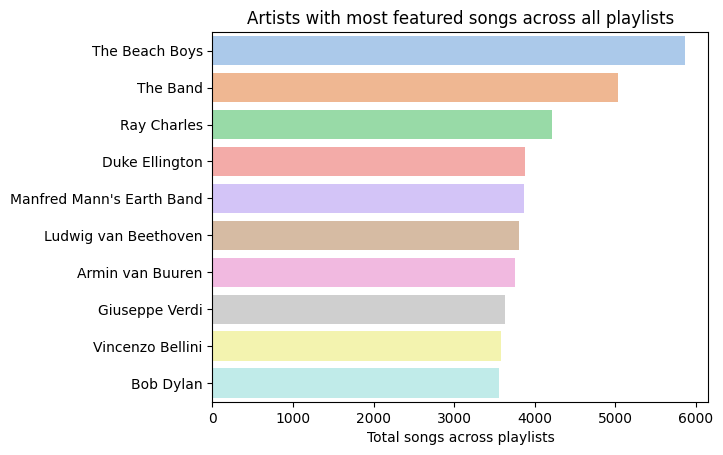

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt 

# Step 1: Group by artist_name and count the apparence
artist_counts = summary_table.groupBy("artist_name").count()

# Step 2: Sort descending by the apparence
sorted_artist_counts = artist_counts.orderBy("count", ascending = False)

# Step 3: Convert to pandas to plot data
artist_counts_pd = sorted_artist_counts.limit(10).toPandas()

# Step 4: Take the values and name of artists
values = artist_counts_pd['count'].tolist()
names = artist_counts_pd['artist_name'].tolist()

# Step 5: Plot data with seaborn
ax = sns.barplot(y = names, x = values, palette= 'pastel')
ax.set_title('Artists with most featured songs across all playlists')
ax.set_xlabel('Total songs across playlists')

- Top 10 artists and music genres are most popular in the world

In [9]:
from pyspark.sql import functions as F

# Group by artist_name and calculate mean of followers 
artist_fl = summary_table.groupBy('artist_name').agg(F.mean('followers').alias('followers'))

# Sort by followers in descending order
sorted_artist_fl = artist_fl.orderBy('followers', ascending = False).limit(10)

sorted_artist_fl.show(truncate = False)

+-------------+------------+
|artist_name  |followers   |
+-------------+------------+
|Arijit Singh |1.23616624E8|
|Taylor Swift |1.22781005E8|
|Ed Sheeran   |1.16283003E8|
|Billie Eilish|1.00208733E8|
|Ariana Grande|1.00144929E8|
|Drake        |9.2294533E7 |
|The Weeknd   |9.2004576E7 |
|Eminem       |9.0916937E7 |
|Bad Bunny    |8.600057E7  |
|Justin Bieber|7.7680104E7 |
+-------------+------------+



In [10]:
# Group by genres and calculate mean of popularity
popular_genres = summary_table.groupBy('genres').agg(F.mean('popularity').alias('avg_popularity'))

# Sort by popularity in descending order
sorted_popular_genres = popular_genres.orderBy('avg_popularity', ascending = False).limit(10)

sorted_popular_genres.show(truncate = False)

+----------------------+-----------------+
|genres                |avg_popularity   |
+----------------------+-----------------+
|el paso indie         |85.0             |
|ambient pop           |85.0             |
|big room              |83.72384428223845|
|r&drill               |83.0             |
|south carolina hip hop|83.0             |
|musica tocantinense   |82.83552631578948|
|pittsburgh rap        |82.502722323049  |
|dutch edm             |82.25934579439253|
|nashville hip hop     |82.0             |
|barbadian pop         |81.27737226277372|
+----------------------+-----------------+



### Data Preprocessing

1. Check null values in each columns

In [11]:
from pyspark.sql import functions as F
# Function to check null values in each columns

def count_nulls(df):
    # Calculate null values in each columns
    null_counts = df.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df.columns])
    
    # Show results
    null_counts.show()

In [12]:
print(count_nulls(summary_table))

+--------+---------+-----------+------+---------+----------+----------+------------+------------+--------+----+-------+---+------------+------+-----+--------+-----+-----------+------------+----------------+--------+-------+-----+
|album_id|artist_id|artist_name|genres|followers|popularity|link_image|total_tracks|release_date|track_id|name|preview|url|danceability|energy|  key|loudness| mode|speechiness|acousticness|instrumentalness|liveness|valence|tempo|
+--------+---------+-----------+------+---------+----------+----------+------------+------------+--------+----+-------+---+------------+------+-----+--------+-----+-----------+------------+----------------+--------+-------+-----+
|       0|        0|          0| 87067|        0|         0|         0|           0|      134902|       0|  52| 523833|  0|       81863| 81863|81863|   81863|81863|      81863|       81863|           81863|   81863|  81863|81863|
+--------+---------+-----------+------+---------+----------+----------+---------

2. Drop those columns not affect to build the model

In [13]:
tracks = summary_table.drop('release_date', 'total_tracks', 'mode')

In [14]:
print(count_nulls(tracks))

+--------+---------+-----------+------+---------+----------+----------+--------+----+-------+---+------------+------+-----+--------+-----------+------------+----------------+--------+-------+-----+
|album_id|artist_id|artist_name|genres|followers|popularity|link_image|track_id|name|preview|url|danceability|energy|  key|loudness|speechiness|acousticness|instrumentalness|liveness|valence|tempo|
+--------+---------+-----------+------+---------+----------+----------+--------+----+-------+---+------------+------+-----+--------+-----------+------------+----------------+--------+-------+-----+
|       0|        0|          0| 87067|        0|         0|         0|       0|  52| 523833|  0|       81863| 81863|81863|   81863|      81863|       81863|           81863|   81863|  81863|81863|
+--------+---------+-----------+------+---------+----------+----------+--------+----+-------+---+------------+------+-----+--------+-----------+------------+----------------+--------+-------+-----+

None


In [15]:
# Function to return shape of table
def shape(df):
    num_rows = df.count()
    nums_cols = len(df.columns)
    
    return (num_rows, nums_cols)

In [16]:
print(shape(tracks))

(2390425, 21)


Vì những cột name là tên bài hát không có nên ta sẽ bỏ những hàng không có tên bài hát đó đi vì nếu không có tên bài hát thì không thể nào recommend cho user

In [17]:
tracks = tracks.dropna(subset = ['name'])
print(shape(tracks))

(2390373, 21)


Vì những cột features như là danceability, energy, acousticness, valence, tempo là những features quan trọng cho việc phân loại theo cảm xúc nên nếu là null values ta sẽ loại bỏ hết những hàng đó

In [18]:
# List of columns need to be dropped
cols_to_drop = ['danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

# Drop those columns above
tracks = tracks.dropna(subset = cols_to_drop)
print(shape(tracks))

(2308510, 21)


In [19]:
print(count_nulls(tracks))

+--------+---------+-----------+------+---------+----------+----------+--------+----+-------+---+------------+------+---+--------+-----------+------------+----------------+--------+-------+-----+
|album_id|artist_id|artist_name|genres|followers|popularity|link_image|track_id|name|preview|url|danceability|energy|key|loudness|speechiness|acousticness|instrumentalness|liveness|valence|tempo|
+--------+---------+-----------+------+---------+----------+----------+--------+----+-------+---+------------+------+---+--------+-----------+------------+----------------+--------+-------+-----+
|       0|        0|          0| 81748|        0|         0|         0|       0|   0| 509818|  0|           0|     0|  0|       0|          0|           0|               0|       0|      0|    0|
+--------+---------+-----------+------+---------+----------+----------+--------+----+-------+---+------------+------+---+--------+-----------+------------+----------------+--------+-------+-----+

None


### Build Recommendation System

#### 1/ Recommend songs by name of song using Content-based Filtering 

In [20]:
summary_table.unpersist()
tracks.persist()

DataFrame[album_id: string, artist_id: string, artist_name: string, genres: string, followers: int, popularity: int, link_image: string, track_id: string, name: string, preview: string, url: string, danceability: float, energy: float, key: int, loudness: float, speechiness: float, acousticness: float, instrumentalness: float, liveness: float, valence: float, tempo: float]

In [21]:
tracks_for_cbf = tracks
print(f"Number of unique genres: {tracks_for_cbf.select('genres').distinct().count()}")

Number of unique genres: 2877


1. Find the similarities between input song with each song in dataset

Content-based filtering cung cấp các đề xuất được thiết kế riêng bằng cách tập trung vào sở thích cá nhân, sắp xếp hiệu quả các tùy chọn với sở thích và mối quan tâm riêng của từng người dùng. Điều này thường đạt được thông qua các kỹ thuật như cosin similarities, đo lường độ tương đồng giữa vectơ người dùng (đại diện cho sở thích của người dùng) và hồ sơ mục. Mô hình không cần bất kỳ dữ liệu nào về người dùng khác vì các đề xuất dành riêng cho người dùng này. Điều này giúp dễ dàng mở rộng quy mô cho nhiều người dùng hơn. Mô hình có thể nắm bắt được sở thích cụ thể của người dùng và có thể đề xuất các mặt hàng ngách mà rất ít người dùng khác quan tâm.

Content-based filtering delivers tailored recommendations by focusing on individual preferences, effectively aligning options with each user's unique tastes and interests. This is often achieved through techniques like cosine similarity, which measures the similarity between the user vector (representing the user's preferences) and the item profile. The model doesn't need any data about other users, since the recommendations are specific to this user. This makes it easier to scale to a large number of users. The model can capture the specific interests of a user, and can recommend niche items that very few other users are interested in.

- Filtering null values in genres and preview columns to empty space ""

In [22]:
from pyspark.sql.functions import col, when

tracks_for_cbf = tracks_for_cbf.withColumn(
    "genres", when(col("genres").isNotNull(), col("genres")).otherwise("")
)

In [23]:
tracks_for_cbf = tracks_for_cbf.withColumn(
    "preview", when(col("preview").isNotNull(), col("preview")).otherwise("")
)

In [24]:
print(count_nulls(tracks_for_cbf))

+--------+---------+-----------+------+---------+----------+----------+--------+----+-------+---+------------+------+---+--------+-----------+------------+----------------+--------+-------+-----+
|album_id|artist_id|artist_name|genres|followers|popularity|link_image|track_id|name|preview|url|danceability|energy|key|loudness|speechiness|acousticness|instrumentalness|liveness|valence|tempo|
+--------+---------+-----------+------+---------+----------+----------+--------+----+-------+---+------------+------+---+--------+-----------+------------+----------------+--------+-------+-----+
|       0|        0|          0|     0|        0|         0|         0|       0|   0|      0|  0|           0|     0|  0|       0|          0|           0|               0|       0|      0|    0|
+--------+---------+-----------+------+---------+----------+----------+--------+----+-------+---+------------+------+---+--------+-----------+------------+----------------+--------+-------+-----+

None


- Tokenizing the genres column and Applying CountVectorizer to count the appearance of each word in genres

In [25]:
from pyspark.ml.feature import Tokenizer, CountVectorizer

# Tokennize the word in genres column
tokenizer = Tokenizer(inputCol="genres", outputCol="tokens")
tracks_for_cbf = tokenizer.transform(tracks_for_cbf)

# Apply CountVectorizer to the tokenized data to count the appearance of those unique word of genres
cv = CountVectorizer(inputCol = "tokens", outputCol = "raw_features")
cv_model = cv.fit(tracks_for_cbf)
tracks_for_cbf = cv_model.transform(tracks_for_cbf)
tracks_for_cbf.show(3, truncate = False)

+----------------------+----------------------+-----------+----------------+---------+----------+----------------------------------------------------------------+----------------------+-------------------+-----------------------------------------------------------------------------------------------------------+-----------------------------------------------------+------------+------+---+--------+-----------+------------+----------------+--------+-------+-------+-------------------+------------------------+
|album_id              |artist_id             |artist_name|genres          |followers|popularity|link_image                                                      |track_id              |name               |preview                                                                                                    |url                                                  |danceability|energy|key|loudness|speechiness|acousticness|instrumentalness|liveness|valence|tempo  |tokens             |

- Applying Min-Max-Scaler for features columnns below to ensure those features in range [0:1]

In [26]:
from pyspark.sql.functions import min, max

cols_to_scale = ['key', 'loudness', 'speechiness', 'liveness', 'instrumentalness', 'valence', 'energy', 'danceability', 'acousticness', 'tempo']

def min_max_scaler(df, columns_to_scale):
    scaled_df = df
    
    for col_name in columns_to_scale:
        # Calculate min and max values for the column
        min_val = df.agg(min(F.col(col_name))).first()[0]
        max_val = df.agg(max(F.col(col_name))).first()[0]
        
        # Apply min-max scaling 
        scaled_df = scaled_df.withColumn(col_name, (F.col(col_name) - min_val) / (max_val - min_val))
    return scaled_df

In [27]:
tracks_for_cbf = min_max_scaler(tracks_for_cbf, cols_to_scale)
tracks_for_cbf.show(3, truncate = False)

+----------------------+----------------------+-----------+----------------+---------+----------+----------------------------------------------------------------+----------------------+-------------------+-----------------------------------------------------------------------------------------------------------+-----------------------------------------------------+------------------+------------------+-------------------+------------------+--------------------+-------------------+----------------+-------------------+------------------+-------------------+-------------------+------------------------+
|album_id              |artist_id             |artist_name|genres          |followers|popularity|link_image                                                      |track_id              |name               |preview                                                                                                    |url                                                  |danceability      |energy 

- Combine column that after applying CountVectorizer for genres columns is raw_features with those features columns like danceability, acousticness, tempo, ... so on

In [28]:
from pyspark.ml.feature import VectorAssembler

# Columns need to be combined
cols_combined = ['raw_features', 'key', 'loudness', 'speechiness', 'liveness', 'instrumentalness', 'valence', 'energy', 'danceability', 'acousticness', 'tempo']

# Assemble features (combine genre features and numerical features)
assembler = VectorAssembler(inputCols = cols_combined, outputCol = "combined_features")
tracks_for_cbf = assembler.transform(tracks_for_cbf)
tracks_for_cbf.show(5, truncate = False)

+----------------------+----------------------+-----------+----------------+---------+----------+----------------------------------------------------------------+----------------------+-------------------+-----------------------------------------------------------------------------------------------------------+-----------------------------------------------------+-------------------+------------------+-------------------+------------------+--------------------+-------------------+---------------------+-------------------+-------------------+-------------------+-------------------+------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|album_id              |artist_id             |artist_name|genres          |followers|popularity|link_image      

- Apply Normalizer for vector by L2 norm, it means the length of vector will be 1

In [29]:
# from pyspark.ml.feature import Normalizer

# # Normalize the raw_features (cosine similarity requires normalized vectors)
# normalizer = Normalizer(inputCol = "combined_features", outputCol = "normalized_features", p = 2)
# tracks_for_cbf = normalizer.transform(tracks_for_cbf)
# tracks_for_cbf.show(5, truncate = False)

- Calculate the length (magnitude) of the combined_features vectors can be called ||x|| 

In [30]:
# from pyspark.sql.functions import udf
# from pyspark.sql.types import FloatType
# import math

# def length_vector(vector):
#     return float(math.sqrt(sum([x**2 for x in vector])))

# length_vector_udf = udf(length_vector, FloatType())

# tracks_for_cbf = tracks_for_cbf.withColumn("length_vector", length_vector_udf(tracks_for_cbf['combined_features']))

# tracks_for_cbf.show(3, truncate = False)

2. Build the recommend songs by name

- Function to calculate Consine Similarity

In [31]:
# def cosine_similarity(v1, v2):
#     dot_product = float(v1.dot(v2))
#     norm_v1 = float(v1.norm(2))
#     norm_v2 = float(v2.norm(2))
#     return dot_product/ (norm_v1 * norm_v2)

- When users search a song, the system will find songs that have the same song name with the input song and return in a list for users to choose

In [32]:
def get_similar_songs(song_name, artist_name, df):
    if song_name is None:
        # Case 1: Search by artist name
        target_artist = df.filter(F.lower(col("artist_name")).contains(artist_name.lower()))
        album_songs_of_artist = target_artist.orderBy(col("followers").desc(), col("popularity").desc())
        album_songs_of_artist.select("artist_name", "name", "track_id", "genres").distinct().show(5, truncate = False)
    else:
        # Case 2: Search by name of songs
        target_songs = df.filter(F.lower(col("name")).contains(song_name.lower()))
        
        related_songs = target_songs.orderBy(col("followers").desc(), col("popularity").desc())
        related_songs.select("artist_name", "name", "track_id", "genres").distinct().show(5, truncate = False)
    return 

In [33]:
get_similar_songs(song_name= None, artist_name= "Пабло", df = tracks_for_cbf)

+-----------+-------------+----------------------+------+
|artist_name|name         |track_id              |genres|
+-----------+-------------+----------------------+------+
|Пабло      |Ронин        |0ZBltNeyAIWOcMsswTzEMH|      |
|Пабло      |В урагане дым|3mzqzcQVbY4p0ORBrGbb5P|      |
|Пабло      |Рим          |7HxGrqIc22aNTbXzml5xsS|      |
|Пабло      |Антигерой    |2idvBuXOzUDqG24IiWtwLl|      |
|Пабло      |Рекрут       |4c5f1whawGRN2IDMfeaFxX|      |
+-----------+-------------+----------------------+------+
only showing top 5 rows



In [34]:
get_similar_songs(song_name= None, artist_name = "taylor swift", df= tracks_for_cbf)

+------------+------------------------------+----------------------+------+
|artist_name |name                          |track_id              |genres|
+------------+------------------------------+----------------------+------+
|Taylor Swift|Guilty as Sin?                |0W0iAC1VGlB82PI6elxFYf|pop   |
|Taylor Swift|Clara Bow                     |1UlhrRvYzbHEyugEDspXUB|pop   |
|Taylor Swift|The Alchemy                   |1dhMTsEZz6ZEquGvmzVoHn|pop   |
|Taylor Swift|But Daddy I Love Him          |5og4Qzt92jJzVDkOtSEilb|pop   |
|Taylor Swift|Who’s Afraid of Little Old Me?|36t6frENUtCYKuZus6aYDO|pop   |
+------------+------------------------------+----------------------+------+
only showing top 5 rows



In [35]:
get_similar_songs(song_name= None, artist_name= "justin bieber", df= tracks_for_cbf)

+-------------+----------------+----------------------+------------+
|artist_name  |name            |track_id              |genres      |
+-------------+----------------+----------------------+------------+
|Justin Bieber|Boyfriend       |3UGIZ8qcrMTwzLbx6Kttqt|pop         |
|Justin Bieber|Believe         |6ImYcmDP7WamwVBbZeHUTy|pop         |
|Justin Bieber|Die In Your Arms|2eHs8Swb16qSKatrLKnWKP|canadian pop|
|Justin Bieber|Fall            |5dQZbRbOMahlP55xeL0mNW|canadian pop|
|Justin Bieber|Be Alright      |4DmJUNY2LJhbl4ClUpa38T|canadian pop|
+-------------+----------------+----------------------+------------+
only showing top 5 rows



In [36]:
#load table into HDFS
tracks_for_cbf = tracks_for_cbf.select('album_id', 'artist_name', 'genres', 
                                       'followers', 'popularity', 'link_image', 
                                       'url', 'track_id', 'name', 'preview', 'combined_features')

hdfs_rcm_model_path = "hdfs://namenode:9000/datalake/models/rcm_bcf_model"
tracks_for_cbf.write.format('parquet').option('header', 'true').mode('overwrite').save(hdfs_rcm_model_path)

In [37]:
#read again from HDFS
tracks_for_cbf = spark.read.parquet("hdfs://namenode:9000/datalake/models/rcm_bcf_model")
tracks_for_cbf.cache()

DataFrame[album_id: string, artist_name: string, genres: string, followers: int, popularity: int, link_image: string, url: string, track_id: string, name: string, preview: string, combined_features: vector]

In [38]:
tracks_for_cbf.show()

+--------------------+--------------------+------------+---------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|            album_id|         artist_name|      genres|followers|popularity|          link_image|                 url|            track_id|                name|             preview|   combined_features|
+--------------------+--------------------+------------+---------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|000mwAZN63acYRoma...|          The Motans|romanian pop|   443315|        50|https://i.scdn.co...|https://open.spot...|0ELgARllaLbCyo57R...|       Café de Flore|https://p.scdn.co...|(1681,[0,192,1671...|
|000mwAZN63acYRoma...|          The Motans|romanian pop|   443315|        50|https://i.scdn.co...|https://open.spot...|3F7VMdlHX2CRLT6CA...|     Tot ce contează|https://p.scdn.co...|(1

- Find songs having similarities with the chosen song by users

In [39]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

def recommend_songs_by_chosen_song(track_id, df, top_n = 5):
    # Filter all tracks based on track_id
    track_list = df.filter(df["track_id"] == track_id)
    track_list.cache()
    
    # Take the first track and normalized feature value
    track = track_list.first()
    input_song_name, input_features = track['name'], track['combined_features']
    
    if track is not None:
        # If the chosen song has null genre, we will rcm 5 songs in same album of the input song
        if track['genres'] == "":
            tmp = track['album_id']
            
            rcm_random = df.filter(col("album_id") == tmp).orderBy(F.rand()).select("artist_name", "followers", "name", 
                                                                                    "track_id", "link_image", "url", "preview").limit(5)
            return rcm_random
    else:
        print(f"{input_song_name} does not exist in dataset")
        return None
    
    # Take all the genres in the track_list
    genres_list = track_list.select("genres").rdd.flatMap(lambda x: x).filter(lambda genres: genres != "").collect() # bước này lọc ra genres null
    print(genres_list)
    
    # Filter all songs have genres in genres_list, after droping genres column and then distinct by track_id to decrease to calculate
    filtered_songs = df.filter(df['genres'].isin(genres_list))
    filtered_songs = filtered_songs.drop('genres').dropDuplicates(['track_id'])
    
    # print("Number of similar songs before limit: ", filtered_songs.count())
    #filtered_songs = filtered_songs.limit(10000)        
    print("Number of similar songs after limit: ", filtered_songs.count())
    
    # Calculate cosine similarity between the input song and all songs in the dataset
    norm_v2 = float(input_features.norm(2))
    
    def cosine_similarity(v1, v2, norm_v2):
        dot_product = float(v1.dot(v2))
        norm_v1 = float(v1.norm(2))
        #norm_v2 = float(v2.norm(2))
        return dot_product / (norm_v1 * norm_v2)
    
    # Calculae cosine similarity between input_song all songs after filtering
    cosine_similarity_udf = udf(lambda x: cosine_similarity(x, input_features, norm_v2), FloatType())
    
    # Apply function above, save the result in similarity_scores column(new column)
    top_recommendations = filtered_songs.withColumn("similarity_scores", cosine_similarity_udf(filtered_songs['combined_features']))

    # Order descending by similarity_scores 
    top_recommendations = top_recommendations.orderBy("similarity_scores", ascending= False).limit(top_n)
    
    # Show the result
    top_recommendations = top_recommendations.select("artist_name", "followers", "name", "similarity_scores", 
                                                     "track_id", "link_image", "url", "preview")
    
    return top_recommendations

In [41]:
rcm = recommend_songs_by_chosen_song(track_id = "1q9pBaYcydq7LyYwD8SEBs", df = tracks_for_cbf)
rcm.show(truncate = False)

24/12/20 05:39:32 WARN CacheManager: Asked to cache already cached data.
24/12/20 05:39:34 WARN MemoryStore: Not enough space to cache rdd_393_1 in memory! (computed 73.7 MiB so far)
24/12/20 05:39:34 WARN BlockManager: Persisting block rdd_393_1 to disk instead.
24/12/20 05:39:40 WARN MemoryStore: Not enough space to cache rdd_393_1 in memory! (computed 73.7 MiB so far)


['pop', 'canadian pop']


24/12/20 05:39:41 WARN MemoryStore: Not enough space to cache rdd_393_1 in memory! (computed 73.7 MiB so far)


Number of similar songs after limit:  23877


24/12/20 05:39:42 WARN MemoryStore: Not enough space to cache rdd_393_1 in memory! (computed 73.7 MiB so far)


+-------------+---------+------------------+-----------------+----------------------+----------------------------------------------------------------+-----------------------------------------------------+-------+
|artist_name  |followers|name              |similarity_scores|track_id              |link_image                                                      |url                                                  |preview|
+-------------+---------+------------------+-----------------+----------------------+----------------------------------------------------------------+-----------------------------------------------------+-------+
|Justin Bieber|77680104 |Down To Earth     |1.0              |1q9pBaYcydq7LyYwD8SEBs|https://i.scdn.co/image/ab6761610000e5eb8ae7f2aaa9817a704a87ea36|https://open.spotify.com/track/1q9pBaYcydq7LyYwD8SEBs|       |
|Justin Bieber|77680104 |Down To Earth     |1.0              |3H040I1iKknjbO2pU6v0zD|https://i.scdn.co/image/ab6761610000e5eb8ae7f2aaa9817a704a87ea3

Exception in thread "serve RDD 415" java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:713)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:757)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:675)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:641)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:617)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:574)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:532)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:65)


In [42]:
tracks_for_cbf.filter(tracks_for_cbf['artist_name'] == "Justin Bieber").select('track_id').show(truncate = False)

+----------------------+
|track_id              |
+----------------------+
|1q9pBaYcydq7LyYwD8SEBs|
|4bPeekGfzuqkmlpKiJur5o|
|0ffOWJVrYmtKcmQJbPWuhc|
|6eDApnV9Jdb1nYahOlbbUh|
|0yIywEquxORnu1dR0WYsdN|
|4nTjkWK590oBDcnIxTr1mI|
|69ghzc538EQSVon2Gm3wrr|
|1q9pBaYcydq7LyYwD8SEBs|
|4bPeekGfzuqkmlpKiJur5o|
|0ffOWJVrYmtKcmQJbPWuhc|
|6eDApnV9Jdb1nYahOlbbUh|
|0yIywEquxORnu1dR0WYsdN|
|4nTjkWK590oBDcnIxTr1mI|
|69ghzc538EQSVon2Gm3wrr|
|0Pd4lsvSDPkcNCxbcz0UeV|
|1c3KqIIDoomFj4551PD1A5|
|3O5zp6tOdGFWi0NdzC0frI|
|7xapw9Oy21WpfEcib2ErSA|
|192yj763UcVbfyxFrVmIac|
|3RH9idbxUAMcUldet2ormp|
+----------------------+
only showing top 20 rows



In [43]:
# tracks_for_cbf.filter(tracks_for_cbf['artist_name'] == 'Justin Bieber').show(truncate = False)
spark.catalog.clearCache()

#### 2/ Recommend songs by mood and genres using K-means Clustering

1. Using Standard Scaling to scale

In [44]:
tracks_cleaned_mood = tracks.drop('album_id')

- Function to normalize by using standard scailing method

In [45]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, stddev

def z_score(df):
    
    # Identify numerical columns
    num_cols = ['key', 'loudness', 'speechiness', 'liveness', 'instrumentalness', 'valence', 'energy', 'danceability', 'acousticness', 'tempo']

    # Create a list to store transformations
    z_score_cols = []

    for col_name in num_cols:
        # Compute mean and standard deviation for the column
        mean_val = df.select(mean(col(col_name))).first()[0]
        stddev_val = df.select(stddev(col(col_name))).first()[0]

        # Apply Z-score formula
        z_score_cols.append(((col(col_name) - mean_val) / stddev_val).alias(col_name))

    # Add non-numerical columns to the result
    other_cols = [col(c) for c in df.columns if c not in num_cols]
    result_cols = other_cols + z_score_cols

    # Return the updated DataFrame
    z_score_df = df.select(*result_cols)
    return z_score_df

z_score_df = z_score(tracks_cleaned_mood)

In [46]:
z_score_df.show(5)

+--------------------+-----------+----------------+---------+----------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-------------------+
|           artist_id|artist_name|          genres|followers|popularity|          link_image|            track_id|               name|             preview|                 url|                 key|            loudness|         speechiness|            liveness|   instrumentalness|             valence|              energy|        danceability|        acousticness|              tempo|
+--------------------+-----------+----------------+---------+----------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+------------

2. Using K-means algorithm to catgorize moods based on those important features

In [47]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import PCA
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col, udf
from pyspark.sql.types import ArrayType, FloatType

# Select relevant features
features_cols = ['valence', 'energy', 'danceability', 'acousticness', 'tempo']

# Assemble the features into a single vector column
vector_assembler = VectorAssembler(inputCols=features_cols, outputCol="features")
features_df = vector_assembler.transform(z_score_df)

# Apply KMeans with 3 clusters
kmeans = KMeans(k=3, seed=42, featuresCol="features", predictionCol="mood_score")
kmeans_model = kmeans.fit(features_df)

# Get cluster centers
cluster_centers = kmeans_model.clusterCenters()
cluster_features_list = [center.tolist() for center in cluster_centers]

# Create DataFrame with the cluster centers
cluster_features = spark.createDataFrame(cluster_features_list, schema=features_cols)
cluster_features.show()

"""You can see the cluster features df:
1. with high valence, energy, and danceability -> maybe "Happy"
2. with low valence, energy, danceability but high acouticness -> maybe "Sad"
3. Remaining features -> will be "Neutral" """

24/12/20 05:41:48 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/12/20 05:41:48 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


+--------------------+-------------------+-------------------+--------------------+--------------------+
|             valence|             energy|       danceability|        acousticness|               tempo|
+--------------------+-------------------+-------------------+--------------------+--------------------+
| -0.7983418709676718|-1.2392503680796556|-0.7232371667488507|  1.2652882826853076|-0.42848108929039797|
|  0.8040491944176108|0.33708813245683417| 0.7581106913945057|-0.27145915289571315|-0.08122588517133911|
|-0.45256622204725555| 0.5755233049971752|-0.4516598925648024|  -0.689619529759213| 0.47644464590301977|
+--------------------+-------------------+-------------------+--------------------+--------------------+



'You can see the cluster features df:\n1. with high valence, energy, and danceability -> maybe "Happy"\n2. with low valence, energy, danceability but high acouticness -> maybe "Sad"\n3. Remaining features -> will be "Neutral" '

3. Applying PCA to reduce the dimensions of the data to 2 components and Sample 0.01 dataset to plot the data in 2D.

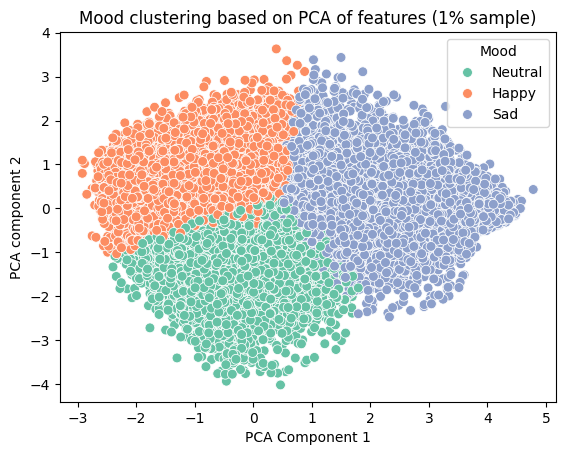

In [49]:
from pyspark.sql.functions import when
import matplotlib.pyplot as plt
import seaborn as sns

# Predict mood clusters
predictions_mood = kmeans_model.transform(features_df)

# Map mood labels
mood_labels = {0: "Sad", 1: "Happy", 2: "Neutral"}
predictions_mood = predictions_mood.withColumn(
    "mood",
    when(col("mood_score") == 0, "Sad")
    .when(col("mood_score") == 1, "Happy")
    .when(col("mood_score") == 2, "Neutral")
)

# Apply PCA to reduce dimensions to 2 components
pca = PCA(k = 2, inputCol = "features", outputCol = "pca_features")
pca_model = pca.fit(predictions_mood)
predictions_pca = pca_model.transform(predictions_mood)

# Extract PCA components for plotting
def extract_pca_components(pca_col):
    if pca_col and len(pca_col) == 2:
        return [float(pca_col[0]), float(pca_col[1])]
    return [float(0), float(0)]  # Default values in case of issues

extract_pca = udf(extract_pca_components, ArrayType(FloatType()))
predictions_pca = predictions_pca.withColumn("pca_components", extract_pca(col("pca_features")))

# Split PCA components into separate columns
predictions_pca = predictions_pca.withColumn("PCA1", col("pca_components")[0])
predictions_pca = predictions_pca.withColumn("PCA2", col("pca_components")[1])

# Take a radom 1% sample of the data 
sample_df = predictions_pca.sample(withReplacement = False, fraction = 0.01, seed = 42)

# Convert the sampled DataFrame to pandas for plotting 
sample_converted_df = sample_df.select("PCA1", "PCA2", "mood").toPandas()

# Scatter plot for PCA components with mood labels
sns.scatterplot(data = sample_converted_df, x = "PCA1", y= "PCA2", hue = "mood", palette= "Set2", s= 50)
plt.title("Mood clustering based on PCA of features (1% sample)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA component 2")
plt.legend(title = "Mood")
plt.show()

In [50]:
predictions_pca.cache()

DataFrame[artist_id: string, artist_name: string, genres: string, followers: int, popularity: int, link_image: string, track_id: string, name: string, preview: string, url: string, key: double, loudness: double, speechiness: double, liveness: double, instrumentalness: double, valence: double, energy: double, danceability: double, acousticness: double, tempo: double, features: vector, mood_score: int, mood: string, pca_features: vector, pca_components: array<float>, PCA1: float, PCA2: float]

In [51]:
predictions_pca.filter(predictions_pca['artist_name'] == 'Mr.Siro').select('artist_name', 'name', 'mood_score', 'mood').show(truncate = False)

24/12/20 05:43:31 WARN MemoryStore: Not enough space to cache rdd_1432_0 in memory! (computed 158.2 MiB so far)
24/12/20 05:43:31 WARN BlockManager: Persisting block rdd_1432_0 to disk instead.
24/12/20 05:43:35 WARN MemoryStore: Not enough space to cache rdd_1432_1 in memory! (computed 41.4 MiB so far)
24/12/20 05:43:35 WARN BlockManager: Persisting block rdd_1432_1 to disk instead.
24/12/20 05:43:41 WARN MemoryStore: Not enough space to cache rdd_1432_1 in memory! (computed 158.5 MiB so far)
24/12/20 05:43:44 WARN MemoryStore: Not enough space to cache rdd_1432_2 in memory! (computed 80.6 MiB so far)
24/12/20 05:43:44 WARN BlockManager: Persisting block rdd_1432_2 to disk instead.
24/12/20 05:43:48 WARN MemoryStore: Not enough space to cache rdd_1432_2 in memory! (computed 158.6 MiB so far)
24/12/20 05:43:50 WARN MemoryStore: Not enough space to cache rdd_1432_3 in memory! (computed 41.6 MiB so far)
24/12/20 05:43:50 WARN BlockManager: Persisting block rdd_1432_3 to disk instead.


+-----------+-----------------------------------------------------------------+----------+----+
|artist_name|name                                                             |mood_score|mood|
+-----------+-----------------------------------------------------------------+----------+----+
|Mr.Siro    |Trái Tim Em Cũng Biết Đau - Piano Version                        |0         |Sad |
|Mr.Siro    |Em - Piano Version                                               |0         |Sad |
|Mr.Siro    |Sống Xa Anh Chẳng Dễ Dàng - Piano Version                        |0         |Sad |
|Mr.Siro    |Em Đã Sai Vì Em Tin - Piano Version                              |0         |Sad |
|Mr.Siro    |Cánh Đồng Yêu Thương - Piano Version                             |0         |Sad |
|Mr.Siro    |Nguyện Làm Tri Kỷ - Piano Version                                |0         |Sad |
|Mr.Siro    |Mashup 5 Hit Songs In 2017                                       |0         |Sad |
|Mr.Siro    |Người Từng Yêu Anh Rất Sâu 

24/12/20 05:43:55 WARN MemoryStore: Not enough space to cache rdd_1432_3 in memory! (computed 158.2 MiB so far)


In [52]:
final_df_mood_genre = predictions_pca
final_df_mood_genre.show(5)

+--------------------+-----------+----------------+---------+----------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+----------+-----+--------------------+--------------------+-----------+----------+
|           artist_id|artist_name|          genres|followers|popularity|          link_image|            track_id|               name|             preview|                 url|                 key|            loudness|         speechiness|            liveness|   instrumentalness|             valence|              energy|        danceability|        acousticness|              tempo|            features|mood_score| mood|        pca_features|      pca_components|       PCA1|      PCA2|
+--------------------+--

4. Build recommendation songs by mood and genre

In [53]:
from pyspark.sql.functions import lit

def recommend_songs_by_mood_genre(df, mood, genre, num_recommend = 5):
    # Filter dataFrame by mood and genre
    filtered_tracks = df.filter(
        (col("mood") == lit(mood)) & (F.lower(col("genres")).contains(genre.lower()))
    )
    
    if filtered_tracks.count() == 0:
        print(f"No tracks found with mood {mood} and genre {genre}. Here are some other suggestions:")
        # If no tracks match both mood and genre, recommend random songs from the same mood
        # But if no tracks match with mood, recommend random songs from the same genre
        mood_tracks = df.filter(col("mood") == lit(mood))
        genre_tracks = df.filter(F.lower(col("genres")).contains(genre.lower()))
        
        if mood_tracks.count() == 0:
            print(f"No tracks found with mood. Showing random suggestions by genre {genre}:")
            genre_recommendations = genre_tracks.orderBy(col("popularity").desc(), col("followers").desc()).limit(num_recommend)
            genre_recommendations.select("artist_name", "name", "genres", "mood", "popularity", "link_image", "url", "preview").show(truncate = False)
        else:
            print(f"No tracks found with genre. Showing random suggesstions by mood {mood}:")
            mood_recommendations = mood_tracks.orderBy(col("popularity").desc(), col("followers").desc()).limit(num_recommend)
            mood_recommendations.select("artist_name", "name", "genres", "mood", "popularity", "link_image", "url", "preview").show(truncate = False)
        return

    recommendations = filtered_tracks.orderBy(col("popularity").desc(), col("followers").desc()).limit(num_recommend)
    
    print(f"Recommendations songs with mood {mood} and genre {genre}:")
    recommendations.select("artist_name", "name", "genres", "mood", "popularity", "link_image", "url", "preview").distinct().show(truncate = False)

In [54]:
recommend_songs_by_mood_genre(final_df_mood_genre, "Sad", "vietnamese melodic", 5)

24/12/20 05:44:03 WARN MemoryStore: Not enough space to cache rdd_1432_1 in memory! (computed 158.5 MiB so far)
24/12/20 05:44:03 WARN MemoryStore: Not enough space to cache rdd_1432_2 in memory! (computed 158.6 MiB so far)
24/12/20 05:44:04 WARN MemoryStore: Not enough space to cache rdd_1432_3 in memory! (computed 158.2 MiB so far)


Recommendations songs with mood Sad and genre vietnamese melodic:


24/12/20 05:44:04 WARN MemoryStore: Not enough space to cache rdd_1432_1 in memory! (computed 158.5 MiB so far)
24/12/20 05:44:05 WARN MemoryStore: Not enough space to cache rdd_1432_2 in memory! (computed 158.6 MiB so far)
24/12/20 05:44:05 WARN MemoryStore: Not enough space to cache rdd_1432_3 in memory! (computed 158.2 MiB so far)


+-----------+----------------------------------+----------------------+----+----------+----------------------------------------------------------------+-----------------------------------------------------+-------+
|artist_name|name                              |genres                |mood|popularity|link_image                                                      |url                                                  |preview|
+-----------+----------------------------------+----------------------+----+----------+----------------------------------------------------------------+-----------------------------------------------------+-------+
|tlinh      |thế giới thần tiên                |vietnamese melodic rap|Sad |67        |https://i.scdn.co/image/ab6761610000e5eb230e62752ca87da1d85d0445|https://open.spotify.com/track/2cJyuhqcXvd6ccvAn8NXsL|null   |
|tlinh      |tình yêu có nghĩa là gì?          |vietnamese melodic rap|Sad |67        |https://i.scdn.co/image/ab6761610000e5eb230e62752ca87

In [55]:
recommend_songs_by_mood_genre(final_df_mood_genre, "Neutral", "v-pop", 5)

24/12/20 05:44:07 WARN MemoryStore: Not enough space to cache rdd_1432_1 in memory! (computed 158.5 MiB so far)
24/12/20 05:44:07 WARN MemoryStore: Not enough space to cache rdd_1432_2 in memory! (computed 158.6 MiB so far)
24/12/20 05:44:08 WARN MemoryStore: Not enough space to cache rdd_1432_3 in memory! (computed 158.2 MiB so far)


Recommendations songs with mood Neutral and genre v-pop:


24/12/20 05:44:08 WARN MemoryStore: Not enough space to cache rdd_1432_1 in memory! (computed 158.5 MiB so far)
24/12/20 05:44:09 WARN MemoryStore: Not enough space to cache rdd_1432_2 in memory! (computed 158.6 MiB so far)
24/12/20 05:44:09 WARN MemoryStore: Not enough space to cache rdd_1432_3 in memory! (computed 158.2 MiB so far)


+-----------+----------------------------------------------+------+-------+----------+----------------------------------------------------------------+-----------------------------------------------------+-------+
|artist_name|name                                          |genres|mood   |popularity|link_image                                                      |url                                                  |preview|
+-----------+----------------------------------------------+------+-------+----------+----------------------------------------------------------------+-----------------------------------------------------+-------+
|tlinh      |những đốm sáng                                |v-pop |Neutral|67        |https://i.scdn.co/image/ab6761610000e5eb230e62752ca87da1d85d0445|https://open.spotify.com/track/1TJtZKZFq2rdh9Wfpm15Nw|null   |
|tlinh      |ghệ iu dấu của em ơi (ft. 52Hz) - Gonpop remix|v-pop |Neutral|67        |https://i.scdn.co/image/ab6761610000e5eb230e62752ca87da1d8

In [56]:
recommend_songs_by_mood_genre(final_df_mood_genre, "Happy", "vietnamese", 5)

24/12/20 05:44:11 WARN MemoryStore: Not enough space to cache rdd_1432_1 in memory! (computed 158.5 MiB so far)
24/12/20 05:44:11 WARN MemoryStore: Not enough space to cache rdd_1432_2 in memory! (computed 158.6 MiB so far)
24/12/20 05:44:12 WARN MemoryStore: Not enough space to cache rdd_1432_3 in memory! (computed 158.2 MiB so far)


Recommendations songs with mood Happy and genre vietnamese:


24/12/20 05:44:12 WARN MemoryStore: Not enough space to cache rdd_1432_1 in memory! (computed 158.5 MiB so far)
24/12/20 05:44:12 WARN MemoryStore: Not enough space to cache rdd_1432_2 in memory! (computed 158.6 MiB so far)
24/12/20 05:44:13 WARN MemoryStore: Not enough space to cache rdd_1432_3 in memory! (computed 158.2 MiB so far)


+-----------+-----------------------+------------------+-----+----------+----------------------------------------------------------------+-----------------------------------------------------+-----------------------------------------------------------------------------------------------------------+
|artist_name|name                   |genres            |mood |popularity|link_image                                                      |url                                                  |preview                                                                                                    |
+-----------+-----------------------+------------------+-----+----------+----------------------------------------------------------------+-----------------------------------------------------+-----------------------------------------------------------------------------------------------------------+
|HIEUTHUHAI |Siêu Sao               |vietnamese hip hop|Happy|70        |https://i.scdn.co/image/